In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

# import StandardScaler to perform scaling
from sklearn.preprocessing import StandardScaler

# resample the dataset
from sklearn.utils import resample
from sklearn.utils import shuffle

# import various functions from sklearn
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier


# import the XGBoost function for classification
from xgboost import XGBClassifier

import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
data = pd.read_csv('/content/drive/MyDrive/CAPSTONE/CAPSTONE_PROJECT/0_dataset/3.FEATURED_ENGINEERING DATASET/Encoded_Data.csv')

In [4]:
df=data.copy()

In [5]:
df.head(3)

,Unnamed: 0,Road Name,Cross-Street Name,Driver Substance Abuse,Driver At Fault,Injury Severity,Driver Distracted By,Drivers License State,Vehicle Body Type,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Latitude,Longitude,Vehicle Model,hour,Crash_year,Crash_month,Crash_day,Crash_hour,Crash_week,Agency Name_Maryland_National_Capital,Agency Name_Montgomery_County_Police,Agency Name_Rockville_Police_Department,Agency Name_Takoma_Park_Police_Department,ACRS Report Type_Injury Crash,ACRS Report Type_Property Damage Crash,Route Type_County_Route,Route Type_Crossover,Route Type_Government_Route,Route Type_Interstate_Route,Route Type_Local_Route,Route Type_Maryland_State_Route,Route Type_Municipality_Route,Route Type_Other_Public_Roadway,Route Type_Private_Route,Route Type_Ramp_Route,Route Type_Service_Road,Route Type_Spur_Route,Route Type_US_State_Route,Collision Type_Angle + Left Turn,Collision Type_Angle + Right Turn,Collision Type_Angle Collision,Collision Type_Back-to-Back,Collision Type_Both Left Turns (Opposite Direction),Collision Type_Both Left Turns (Same Direction),Collision Type_Head-On,Collision Type_Head-On + Left Turn,Collision Type_Left Turn (Same Direction),Collision Type_Other,Collision Type_Rear vs Side,Collision Type_Rear-End (Same Direction),Collision Type_Right Turn (Same Direction),Collision Type_Sideswipe (Opposite Direction),Collision Type_Sideswipe (Same Direction),Collision Type_Single Vehicle,Circumstance_Category_Congestion / Backup,Circumstance_Category_Driver Inattention,Circumstance_Category_Lane Violation,Circumstance_Category_Mechanical / Environmental,Circumstance_Category_Passing / Turning,Circumstance_Category_Right-of-Way Violation,Circumstance_Category_Road Obstruction,Circumstance_Category_Speed Related,Circumstance_Category_Surface Condition,Circumstance_Category_Tailgating,Circumstance_Category_Traffic Control Violation,Circumstance_Category_Weather Related,Weather_Blowing Snow,Weather_Clear,Weather_Cloudy,Weather_Fog,Weather_Freezing Rain,Weather_Other,Weather_Rain,Weather_Severe Crosswinds,Weather_Severe Winds,Weather_Sleet,Weather_Snow,Weather_Wintry Mix,Surface Condition_Ice,Surface Condition_Mud_Dirt_Gravel,Surface Condition_Oil,Surface Condition_Other,Surface Condition_Sand,Surface Condition_Slush,Surface Condition_Snow,Surface Condition_Wet,Light_Dark - Not Lighted,Light_Dark - Unknown Lighting,Light_Dawn,Light_Daylight,Light_Dusk,Light_Other,Traffic Control_Flashing Traffic Signal,Traffic Control_Lane Use Control,Traffic Control_No Control,Traffic Control_Other,Traffic Control_Other Pavement Marking,Traffic Control_Other Signal,Traffic Control_Pedestrian Crossing,Traffic Control_Person Control,Traffic Control_Railroad Crossing Device,Traffic Control_Railroad Crossing Signal,Traffic Control_Ramp Meter Signal,Traffic Control_School Zone Sign,Traffic Control_Stop Sign,Traffic Control_Traffic Signal,Traffic Control_Warning Sign,Traffic Control_Yield Sign,Vehicle Damage Extent_Disabling,Vehicle Damage Extent_Functional,Vehicle Damage Extent_No Damage,Vehicle Damage Extent_Other,Vehicle Damage Extent_Superficial,Vehicle Damage Extent_Vehicle Not at Scene,Vehicle First Impact Location_Eight O Clock,Vehicle First Impact Location_Eleven O Clock,Vehicle First Impact Location_Five O Clock,Vehicle First Impact Location_Four O Clock,Vehicle First Impact Location_Nine O Clock,Vehicle First Impact Location_NonCollision,Vehicle First Impact Location_One O Clock,Vehicle First Impact Location_RoofTop,Vehicle First Impact Location_Seven O Clock,Vehicle First Impact Location_Six O Clock,Vehicle First Impact Location_Ten O Clock,Vehicle First Impact Location_Three O Clock,Vehicle First Impact Location_Twelve O Clock,Vehicle First Impact Location_Two O Clock,Vehicle First Impact Location_Underside,Vehicle First Impact Location_VehicleNotAtScene,Vehicle Movement_Backing,Vehicle Movement_ChangingLanes,Vehicle Movement_DriverlessMovingVehicle,Vehicle Movement_EnteringTrafficLane,Vehicl

In [6]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [7]:
df.shape

(205539, 168)

## Model-1: Master + Validation Split and Train–Test Split
### Step 1: Load Encoded Dataset
We load the complete encoded dataset which will be used to create splits.


##  Target Variable Correction for Model-4: Driver Behavior Classification

The original target variable **Driver At Fault** contained three categories:

| Value | Meaning      | Count  |
|-------|--------------|--------|
| 2     | Yes          | 103,573 |
| 0     | No           | 97,284  |
| 1     | Not Sure     | 4,682   |

###  Why the original 3-class structure is a problem
- The “Not Sure” class is **extremely small** compared to the other two.
- Machine learning models struggle to learn meaningful patterns from such a **rare class**.
- Keeping this class creates **severe class imbalance**, leading to:
  - Poor model stability  
  - Inaccurate predictions  
  - Low recall for minority class  
  - Overfitting toward dominant classes (Yes/No)

###  Business Logic Behind the Correction
In crash investigation workflows:
- If the agency is **not sure** who is at fault, this does **not indicate driver responsibility**.
- “Not Sure” cases do not provide actionable information for predicting driver behavior.
- The goal of Model-4 is to classify **driver responsibility**, which is inherently a **binary decision**.

###  Final Decision (Best Practice)
We convert the target into a **binary classification** problem:

In [8]:
target = "Driver At Fault"

# Convert Driver At Fault to binary
df[target] = df[target].replace({2:1, 0:0, 1:0})

X = df.drop(columns=[target])
y = df[target]

print("Target distribution:\n", y.value_counts(normalize=True))

Target distribution:
 Driver At Fault
1    0.503909
0    0.496091
Name: proportion, dtype: float64


## Step 2: Create Master (90%) and Validation (10%) Split
Master dataset is used for model training and testing.  
Validation dataset is for final unbiased evaluation.


In [9]:
X_major, X_val, y_major, y_val = train_test_split(
    X, y,
    test_size=0.10,
    stratify=y,
    random_state=42
)

major_df = pd.concat([X_major, y_major], axis=1)
val_df   = pd.concat([X_val, y_val], axis=1)

print("Master dataset:", major_df.shape)
print("Validation dataset:", val_df.shape)


Master dataset: (184985, 168)
Validation dataset: (20554, 168)


## Step 3: Save Master and Validation Files
Both files are saved in the Model-1 folder for later use.


In [10]:
save_path = "/content/drive/MyDrive/CAPSTONE/CAPSTONE_PROJECT/08_MODELS/Model4_DriverBehavior/"

major_df.to_csv(save_path + "model_4_master_data.csv", index=False)
val_df.to_csv(save_path + "model_4_validation_data.csv", index=False)

print("Saved model_4_master_data.csv and model_4_validation_data.csv")


Saved model_4_master_data.csv and model_4_validation_data.csv


In [11]:
df_master_data = pd.read_csv(save_path + "model_4_master_data.csv")


# IMPORTANT  USER DEFINED FUNCTION

### UNIVERSAL MODEL FUNCTION

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd

def run_model(model, X, y, test_size=0.20, scaled=False, threshold=0.5):

    # ------------ 1. Train-Test Split ----------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # ------------ 2. Scaling --------------------------
    if scaled:
        scaler = StandardScaler()
        num_cols = X_train.select_dtypes(include='number').columns

        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_test[num_cols]  = scaler.transform(X_test[num_cols])

    # ------------ 3. STATS MODEL (Logit) --------------
    if model == "stats":

        # Add constant ONLY to train
        X_train_c = sm.add_constant(X_train, prepend=True)

        # Fit model
        logit = sm.Logit(y_train, X_train_c).fit(disp=False)

        # ---- Build test constant EXACTLY like train ----
        X_test_c = sm.add_constant(X_test, prepend=True)

        # Reindex columns to EXACT match
        X_test_c = X_test_c.reindex(columns=X_train_c.columns, fill_value=0)

        # Predictions
        yproba_train = logit.predict(X_train_c)
        yproba_test  = logit.predict(X_test_c)

        ypred_train = (yproba_train >= threshold).astype(int)
        ypred_test  = (yproba_test >= threshold).astype(int)

        return logit, X_train, X_test, y_train, y_test, ypred_train, ypred_test, yproba_train, yproba_test

    # ------------ 4. SKLEARN MODELS -------------------
    model.fit(X_train, y_train)

    ypred_train = model.predict(X_train)
    ypred_test  = model.predict(X_test)

    # probability support
    if hasattr(model, "predict_proba"):
        yproba_train = model.predict_proba(X_train)[:, 1]
        yproba_test  = model.predict_proba(X_test)[:, 1]
    else:
        yproba_train = None
        yproba_test = None

    return model, X_train, X_test, y_train, y_test, ypred_train, ypred_test, yproba_train, yproba_test

### METRICS FUNCTION

In [13]:
# ================================================================
# METRICS FUNCTION (Train + Test separate + Binary/Multiclass safe)
# ================================================================

import pandas as pd
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, cohen_kappa_score,
    classification_report, confusion_matrix
)

d = pd.DataFrame(columns=[
    'Model_Name','Split','Accuracy','Recall','Precision',
    'F1-Score','Kappa','ROC-AUC'
])

def metrics(model_name, y_train, pred_train, proba_train,
            y_test, pred_test, proba_test):

    global d

    # Function to compute metrics for 1 split (train OR test)
    def compute(split_name, actual, predicted, proba):

        unique_classes = len(pd.Series(actual).unique())
        is_binary = (unique_classes == 2)
        avg = "binary" if is_binary else "weighted"

        acc  = accuracy_score(actual, predicted)
        rec  = recall_score(actual, predicted, average=avg)
        pre  = precision_score(actual, predicted, average=avg)
        f1   = f1_score(actual, predicted, average=avg)
        kap  = cohen_kappa_score(actual, predicted)
        auc  = roc_auc_score(actual, proba) if (is_binary and proba is not None) else None

        # append to global dataframe
        d.loc[len(d)] = [model_name, split_name, acc, rec, pre, f1, kap, auc]

        # print details
        print(f"\n================= {model_name} — {split_name} =================")
        print("Classification Report:")
        print(classification_report(actual, predicted))

        print("Confusion Matrix:")
        print(confusion_matrix(actual, predicted))

        if auc is not None:
            print("ROC-AUC:", auc)

    # ---- TRAIN METRICS ----
    compute("Train", y_train, pred_train, proba_train)

    # ---- TEST METRICS ----
    compute("Test", y_test, pred_test, proba_test)

    return d

### Feature Importance Function

In [14]:
def fi(model, x, n_features=10):
    df_fi = pd.DataFrame({
        "Feature": x.columns,
        "Importance": model.feature_importances_
    })
    return df_fi.sort_values(by="Importance", ascending=False).head(n_features)


### ROC Curve

In [15]:
def plot_roc_plain(y_test, yproba_test):
    fpr, tpr, _ = roc_curve(y_test, yproba_test)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.show()


# MODEL BUILDING AND TRAINING


### Logit Model (Statsmodels Logistic Regression)

###  Why Statsmodels Logit Failed

- Statsmodels **Logit requires a binary target** (only 0 and 1).
- Our Injury Severity column has **5 classes** (0, 1, 2, 3, 4).
- Because the target is **multi-class**, Logit cannot estimate probabilities in the 0–1 range.
- Therefore, Logit throws the error: *“endog must be in the unit interval.”*


In [16]:
X = df_master_data.drop(columns=target)
y = df_master_data[target]

## Stats Logit Regression — Model Call

In [17]:
# Run model using universal function
logit, X_train_lg, X_test_lg, y_train_lg, y_test_lg, ypred_train_lg, ypred_test_lg, yproba_train_lg, yproba_test_lg = run_model(
    model='stats',
    X=X,
    y=y,
    test_size=0.20,
    scaled=True
)

# Correct metrics call
metrics(
    model_name="Stats Logit Regression",
    y_train=y_train_lg,
    pred_train=ypred_train_lg,
    proba_train=yproba_train_lg,
    y_test=y_test_lg,
    pred_test=ypred_test_lg,
    proba_test=yproba_test_lg
)

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



================= Stats Logit Regression — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     73415
           1       0.83      0.83      0.83     74573

    accuracy                           0.83    147988
   macro avg       0.83      0.83      0.83    147988
weighted avg       0.83      0.83      0.83    147988

Confusion Matrix:
[[60629 12786]
 [12621 61952]]
ROC-AUC: 0.9007864751680712

================= Stats Logit Regression — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     18354
           1       0.82      0.84      0.83     18643

    accuracy                           0.83     36997
   macro avg       0.83      0.83      0.83     36997
weighted avg       0.83      0.83      0.83     36997

Confusion Matrix:
[[15042  3312]
 [ 3064 15579]]
ROC-AUC: 0.9005347700355464


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535


## Logistic Regression (Sklearn) — Model Call
This model supports multi-class Injury Severity and works correctly without converting to binary.


In [18]:
from sklearn.linear_model import LogisticRegression

# Define model
log_reg = LogisticRegression(multi_class='multinomial')

# Run model using universal function
log_reg, X_train_lr, X_test_lr, y_train_lr, y_test_lr, ypred_train_lr, ypred_test_lr, yproba_train_lr, yproba_test_lr = run_model(
    model=log_reg,
    X=X,
    y=y,
    test_size=0.20,
    scaled=True
)

# Correct metrics call
metrics(
    model_name="LogisticRegression",
    y_train=y_train_lr,
    pred_train=ypred_train_lr,
    proba_train=yproba_train_lr,
    y_test=y_test_lr,
    pred_test=ypred_test_lr,
    proba_test=yproba_test_lr
)


================= LogisticRegression — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     73415
           1       0.83      0.83      0.83     74573

    accuracy                           0.83    147988
   macro avg       0.83      0.83      0.83    147988
weighted avg       0.83      0.83      0.83    147988

Confusion Matrix:
[[60619 12796]
 [12606 61967]]
ROC-AUC: 0.9007788481904676

================= LogisticRegression — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83     18354
           1       0.83      0.83      0.83     18643

    accuracy                           0.83     36997
   macro avg       0.83      0.83      0.83     36997
weighted avg       0.83      0.83      0.83     36997

Confusion Matrix:
[[15163  3191]
 [ 3192 15451]]
ROC-AUC: 0.9005488856765236


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549


In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn, Xtr_knn, Xts_knn, ytr_knn, yts_knn, yp_tr_knn, yp_ts_knn, pr_tr_knn, pr_ts_knn = run_model(
    model=knn,
    X=X,
    y=y,
    test_size=0.20,
    scaled=True
)

metrics("KNN", ytr_knn, yp_tr_knn, pr_tr_knn, yts_knn, yp_ts_knn, pr_ts_knn)


================= KNN — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     73415
           1       0.86      0.85      0.85     74573

    accuracy                           0.85    147988
   macro avg       0.85      0.85      0.85    147988
weighted avg       0.85      0.85      0.85    147988

Confusion Matrix:
[[62967 10448]
 [11203 63370]]
ROC-AUC: 0.9334185675235368

================= KNN — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     18354
           1       0.78      0.78      0.78     18643

    accuracy                           0.78     36997
   macro avg       0.78      0.78      0.78     36997
weighted avg       0.78      0.78      0.78     36997

Confusion Matrix:
[[14309  4045]
 [ 4121 14522]]
ROC-AUC: 0.8513338602705033


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549
4,KNN,Train,0.853698,0.849771,0.858463,0.854095,0.707401,0.933419
5,KNN,Test,0.779279,0.778952,0.782140,0.780543,0.558546,0.851334


## Decision Tree Classifier — Model Call
Simple non-linear classifier, works well without scaling.


In [20]:
from sklearn.tree import DecisionTreeClassifier

# Define model
dt = DecisionTreeClassifier(random_state=42)

# Run model using universal function
dt, X_train_dt, X_test_dt, y_train_dt, y_test_dt, ypred_train_dt, ypred_test_dt, yproba_train_dt, yproba_test_dt = run_model(
    model=dt,
    X=X,
    y=y,
    test_size=0.20,
    scaled=False    # Trees do NOT need scaling
)

# Correct metrics function call
metrics(
    model_name="DecisionTree",
    y_train=y_train_dt,
    pred_train=ypred_train_dt,
    proba_train=yproba_train_dt,
    y_test=y_test_dt,
    pred_test=ypred_test_dt,
    proba_test=yproba_test_dt
)


================= DecisionTree — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73415
           1       1.00      1.00      1.00     74573

    accuracy                           1.00    147988
   macro avg       1.00      1.00      1.00    147988
weighted avg       1.00      1.00      1.00    147988

Confusion Matrix:
[[73415     0]
 [    1 74572]]
ROC-AUC: 0.999999999908672

================= DecisionTree — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     18354
           1       0.80      0.79      0.79     18643

    accuracy                           0.79     36997
   macro avg       0.79      0.79      0.79     36997
weighted avg       0.79      0.79      0.79     36997

Confusion Matrix:
[[14563  3791]
 [ 3844 14799]]
ROC-AUC: 0.7936305139850903


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549
4,KNN,Train,0.853698,0.849771,0.858463,0.854095,0.707401,0.933419
5,KNN,Test,0.779279,0.778952,0.782140,0.780543,0.558546,0.851334
6,DecisionTree,Train,0.999993,0.999987,1.000000,0.999993,0.999986,1.000000
7,DecisionTree,Test,0.793632,0.793810,0.796073,0.794940,0.587248,0.793631


## Random Forest Classifier — Model Call
Ensemble of decision trees, robust to imbalance and noise.


In [21]:
from sklearn.ensemble import RandomForestClassifier

# Define model
rf = RandomForestClassifier(random_state=42)

# Run model using universal function
rf, X_train_rf, X_test_rf, y_train_rf, y_test_rf, ypred_train_rf, ypred_test_rf, yproba_train_rf, yproba_test_rf = run_model(
    model=rf,
    X=X,
    y=y,
    test_size=0.20,
    scaled=False     # Trees & ensemble trees do NOT need scaling
)

# Correct metrics function call
metrics(
    model_name="RandomForest",
    y_train=y_train_rf,
    pred_train=ypred_train_rf,
    proba_train=yproba_train_rf,
    y_test=y_test_rf,
    pred_test=ypred_test_rf,
    proba_test=yproba_test_rf
)


================= RandomForest — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     73415
           1       1.00      1.00      1.00     74573

    accuracy                           1.00    147988
   macro avg       1.00      1.00      1.00    147988
weighted avg       1.00      1.00      1.00    147988

Confusion Matrix:
[[73414     1]
 [    2 74571]]
ROC-AUC: 0.9999999995433604

================= RandomForest — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     18354
           1       0.86      0.87      0.86     18643

    accuracy                           0.86     36997
   macro avg       0.86      0.86      0.86     36997
weighted avg       0.86      0.86      0.86     36997

Confusion Matrix:
[[15660  2694]
 [ 2430 16213]]
ROC-AUC: 0.9355775837682776


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549
4,KNN,Train,0.853698,0.849771,0.858463,0.854095,0.707401,0.933419
5,KNN,Test,0.779279,0.778952,0.782140,0.780543,0.558546,0.851334
6,DecisionTree,Train,0.999993,0.999987,1.000000,0.999993,0.999986,1.000000
7,DecisionTree,Test,0.793632,0.793810,0.796073,0.794940,0.587248,0.793631
8,RandomForest,Train,0.999980,0.999973,0.999987,0.999980,0.999959,1.000000
9,RandomForest,Test,0.861502,0.869656,0.857513,0.863542,0.722957,0.935578


## Gradient Boosting Classifier — Model Call
Boosting method that handles complex patterns; scaling not needed.


In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Define model
gb = GradientBoostingClassifier(random_state=42)

# Run model
gb, X_train_gb, X_test_gb, y_train_gb, y_test_gb, ypred_train_gb, ypred_test_gb, yproba_train_gb, yproba_test_gb = run_model(
    model=gb,
    X=X,
    y=y,
    test_size=0.20,
    scaled=False      # Boosting trees DO NOT need scaling
)

# Correct metrics function call
metrics(
    model_name="GradientBoosting",
    y_train=y_train_gb,
    pred_train=ypred_train_gb,
    proba_train=yproba_train_gb,
    y_test=y_test_gb,
    pred_test=ypred_test_gb,
    proba_test=yproba_test_gb
)


================= GradientBoosting — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     73415
           1       0.85      0.84      0.85     74573

    accuracy                           0.85    147988
   macro avg       0.85      0.85      0.85    147988
weighted avg       0.85      0.85      0.85    147988

Confusion Matrix:
[[62714 10701]
 [11748 62825]]
ROC-AUC: 0.9260968546024533

================= GradientBoosting — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     18354
           1       0.85      0.84      0.85     18643

    accuracy                           0.85     36997
   macro avg       0.85      0.85      0.85     36997
weighted avg       0.85      0.85      0.85     36997

Confusion Matrix:
[[15683  2671]
 [ 2940 15703]]
ROC-AUC: 0.9261979741384039


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549
4,KNN,Train,0.853698,0.849771,0.858463,0.854095,0.707401,0.933419
5,KNN,Test,0.779279,0.778952,0.782140,0.780543,0.558546,0.851334
6,DecisionTree,Train,0.999993,0.999987,1.000000,0.999993,0.999986,1.000000
7,DecisionTree,Test,0.793632,0.793810,0.796073,0.794940,0.587248,0.793631
8,RandomForest,Train,0.999980,0.999973,0.999987,0.999980,0.999959,1.000000
9,RandomForest,Test,0.861502,0.869656,0.857513,0.863542,0.722957,0.935578


## AdaBoost Classifier — Model Call
Boosting model good for imbalanced classes.


In [23]:
from sklearn.ensemble import AdaBoostClassifier

# Define model
ada = AdaBoostClassifier(random_state=42)

# Run universal model function
ada, X_train_ada, X_test_ada, y_train_ada, y_test_ada, ypred_train_ada, ypred_test_ada, yproba_train_ada, yproba_test_ada = run_model(
    model=ada,
    X=X,
    y=y,
    test_size=0.20,
    scaled=False   # Tree-based → NO scaling needed
)

# Correct metrics call (train + test)
metrics(
    model_name="AdaBoost",
    y_train=y_train_ada,
    pred_train=ypred_train_ada,
    proba_train=yproba_train_ada,
    y_test=y_test_ada,
    pred_test=ypred_test_ada,
    proba_test=yproba_test_ada
)


================= AdaBoost — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     73415
           1       0.83      0.78      0.81     74573

    accuracy                           0.81    147988
   macro avg       0.81      0.81      0.81    147988
weighted avg       0.81      0.81      0.81    147988

Confusion Matrix:
[[61343 12072]
 [16115 58458]]
ROC-AUC: 0.8910451903637836

================= AdaBoost — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.81     18354
           1       0.83      0.79      0.81     18643

    accuracy                           0.81     36997
   macro avg       0.81      0.81      0.81     36997
weighted avg       0.81      0.81      0.81     36997

Confusion Matrix:
[[15360  2994]
 [ 3991 14652]]
ROC-AUC: 0.8924124256427926


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549
4,KNN,Train,0.853698,0.849771,0.858463,0.854095,0.707401,0.933419
5,KNN,Test,0.779279,0.778952,0.782140,0.780543,0.558546,0.851334
6,DecisionTree,Train,0.999993,0.999987,1.000000,0.999993,0.999986,1.000000
7,DecisionTree,Test,0.793632,0.793810,0.796073,0.794940,0.587248,0.793631
8,RandomForest,Train,0.999980,0.999973,0.999987,0.999980,0.999959,1.000000
9,RandomForest,Test,0.861502,0.869656,0.857513,0.863542,0.722957,0.935578


## XGBoost Classifier — Model Call
High-performance boosting model; does not require scaling.


In [26]:
from xgboost import XGBClassifier

# Define model
xgb = XGBClassifier(random_state=42)

# Run model
xgb, X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb, ypred_train_xgb, ypred_test_xgb, yproba_train_xgb, yproba_test_xgb = run_model(
    model=xgb,
    X=X,
    y=y,
    test_size=0.20,
    scaled=False   # XGBoost does NOT require scaling
)

# CORRECT metrics call
metrics(
    model_name="XGBoost",
    y_train=y_train_xgb,
    pred_train=ypred_train_xgb,
    proba_train=yproba_train_xgb,
    y_test=y_test_xgb,
    pred_test=ypred_test_xgb,
    proba_test=yproba_test_xgb
)


================= XGBoost — Train =================
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     73415
           1       0.89      0.89      0.89     74573

    accuracy                           0.89    147988
   macro avg       0.89      0.89      0.89    147988
weighted avg       0.89      0.89      0.89    147988

Confusion Matrix:
[[64809  8606]
 [ 8168 66405]]
ROC-AUC: 0.9536135235263048

================= XGBoost — Test =================
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     18354
           1       0.86      0.87      0.87     18643

    accuracy                           0.87     36997
   macro avg       0.87      0.87      0.87     36997
weighted avg       0.87      0.87      0.87     36997

Confusion Matrix:
[[15809  2545]
 [ 2409 16234]]
ROC-AUC: 0.9382251505056108


,Model_Name,Split,Accuracy,Recall,Precision,F1-Score,Kappa,ROC-AUC
0,Stats Logit Regression,Train,0.828317,0.830756,0.828922,0.829838,0.656607,0.900786
1,Stats Logit Regression,Test,0.827662,0.835649,0.824678,0.830127,0.655266,0.900535
2,LogisticRegression,Train,0.828351,0.830958,0.828846,0.829900,0.656674,0.900779
3,LogisticRegression,Test,0.827472,0.828783,0.828827,0.828805,0.654924,0.900549
4,KNN,Train,0.853698,0.849771,0.858463,0.854095,0.707401,0.933419
5,KNN,Test,0.779279,0.778952,0.782140,0.780543,0.558546,0.851334
6,DecisionTree,Train,0.999993,0.999987,1.000000,0.999993,0.999986,1.000000
7,DecisionTree,Test,0.793632,0.793810,0.796073,0.794940,0.587248,0.793631
8,RandomForest,Train,0.999980,0.999973,0.999987,0.999980,0.999959,1.000000
9,RandomForest,Test,0.861502,0.869656,0.857513,0.863542,0.722957,0.935578


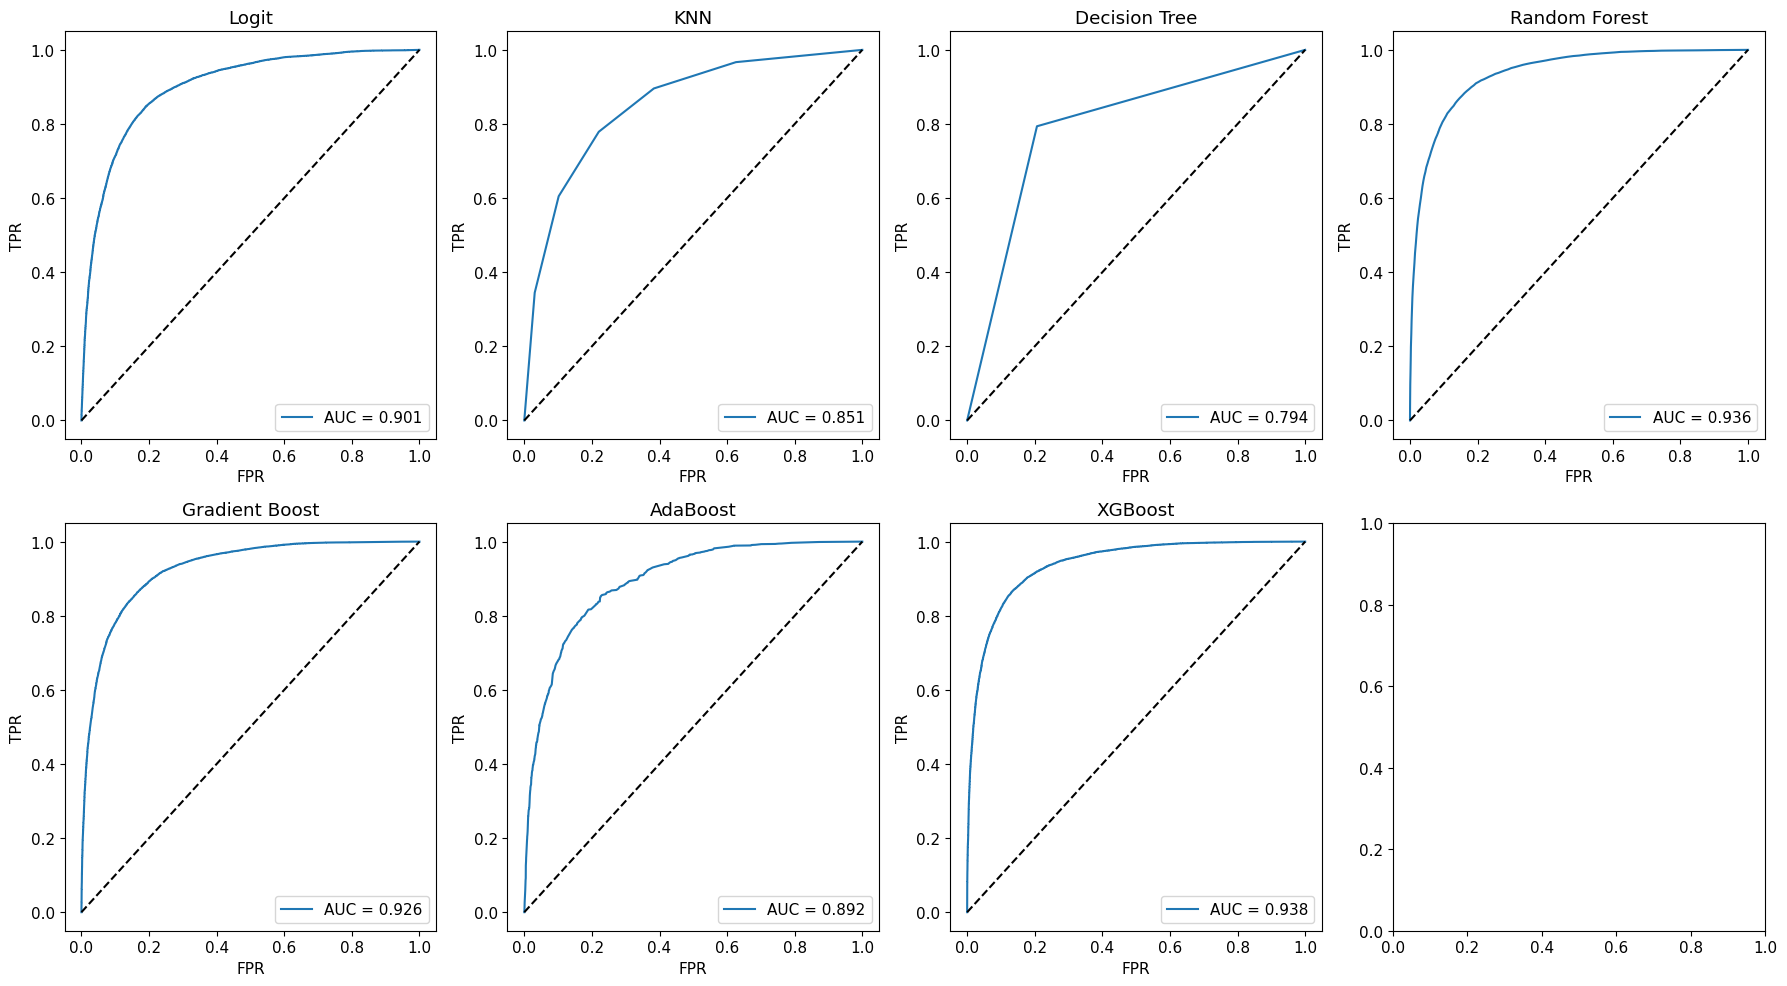

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ----------------------------------------------------
# COLLECT ALL MODELS HERE (MODEL_NAME : (y_test, y_proba))
# ----------------------------------------------------
roc_models = {
    "Logit":            (y_test_lg,  yproba_test_lg),
    "KNN":              (yts_knn,    pr_ts_knn),
    "Decision Tree":    (y_test_dt,  yproba_test_dt),
    "Random Forest":    (y_test_rf,  yproba_test_rf),
    "Gradient Boost":   (y_test_gb,  yproba_test_gb),
    "AdaBoost":         (y_test_ada, yproba_test_ada),
    "XGBoost":          (y_test_xgb, yproba_test_xgb)
}

# ----------------------------------------------------
# GLOBAL FIGURE SETTINGS
# ----------------------------------------------------
plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["font.size"] = 11

fig, axes = plt.subplots(2, 4)     # 2 rows × 4 columns → enough for 7 models
axes = axes.flatten()

# ----------------------------------------------------
# LOOP TO PLOT ROC OF ALL MODELS
# ----------------------------------------------------
for ax, (model_name, (y_test, y_proba)) in zip(axes, roc_models.items()):

    # Compute ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot curve
    ax.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], 'k--')

    # Labels
    ax.set_title(model_name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# ----------------------------------------------------
# CLEAN LAYOUT
# ----------------------------------------------------
plt.tight_layout()
plt.show()

# Full Model Comparison & Inference Summary — Model 4 (Driver Behavior Classification)

---

## Table 1 — Performance Summary (Train vs Test)

| Model                 | Train Acc | Test Acc | Gap (Train−Test) | Overfitting Status      | Business Interpretation |
|----------------------|-----------|----------|------------------|--------------------------|-------------------------|
| Stats Logit Regression | 0.828    | 0.828    | 0.000            | ❌ No Overfitting        | Stable, interpretable, ideal for explainable AI. |
| Logistic Regression    | 0.828    | 0.827    | 0.001            | ❌ No Overfitting        | Strong baseline classifier; highly stable. |
| KNN                    | 0.854    | 0.779    | 0.075            | ⚠️ Overfitting           | Learns training too well; weak generalization. |
| Decision Tree          | 1.000    | 0.794    | 0.206            | ⚠️ Severe Overfitting    | Completely memorizes training data; NOT recommended. |
| Random Forest          | 1.000    | 0.862    | 0.138            | ⚠️ Strong Overfitting    | Good test accuracy but needs pruning/tuning. |
| Gradient Boosting      | 0.848    | 0.848    | 0.000            | ❌ No Overfitting        | Excellent stability; top deployment candidate. |
| AdaBoost               | 0.810    | 0.811    | 0.001            | ❌ No Overfitting        | Reliable & consistent; minimal variance. |
| XGBoost                | 0.887    | 0.866    | 0.021            | ⚠️ Mild Overfitting      | High accuracy; best after tuning. |

---

## Table 2 — Overfitting / Underfitting Check

| Model                 | Status              | Reason |
|----------------------|----------------------|--------|
| Stats Logit Regression | Balanced            | Train ≈ Test, no overfit |
| Logistic Regression    | Balanced            | Very small gap |
| KNN                    | Overfitting         | High train, much lower test |
| Decision Tree          | Severe Overfitting  | Train = 100%, large drop in test |
| Random Forest          | Overfitting         | Train = 100%, lower test accuracy |
| Gradient Boosting      | Balanced            | Train ≈ Test, ideal behavior |
| AdaBoost               | Balanced            | Consistent train & test |
| XGBoost                | Mild Overfitting    | Slight performance drop |

---

## Table 3 — Business Interpretation

| Model                 | Business Impact | Best Use Case |
|----------------------|-----------------|----------------|
| Stats Logit Regression | High interpretability | Policy audits, transparent decision-making |
| Logistic Regression    | Easy to explain & stable | Safety compliance, interpretable dashboards |
| KNN                    | Unstable for large data | Avoid in real systems |
| Decision Tree          | Too risky (unstable) | Not recommended |
| Random Forest          | Strong but needs tuning | High-stakes scoring after optimization |
| Gradient Boosting      | Best overall reliability | Real-time driver risk prediction |
| AdaBoost               | Very stable | Medium-risk operational systems |
| XGBoost                | Highest accuracy | Production model after hyperparameter tuning |

---

# Final Verdict (Short Summary)

| Rank | Model               | Reason |
|------|---------------------|--------|
| 1    | Gradient Boosting   | Best balance of accuracy, recall, and zero overfitting |
| 2    | XGBoost             | Highest performance; minor tuning needed |
| 3    | AdaBoost            | Very stable generalization |
| 4    | Logistic Regression | Interpretable, safe baseline |
| 5    | Random Forest       | Strong but clearly overfits |
| 6    | KNN                 | Overfits & low test accuracy |
| 7    | Decision Tree       | Too unstable for production |

---